# 05 - Weather time series data
Goal: fetch 2m temperature via Open-Meteo, interpolate missing values, aggregate to 3h steps, and start EDA.

In [ ]:
from pathlib import Path
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PROJECT_ROOT = Path('..').resolve()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from Model.time_series import OpenMeteoHistoricalRepository, TimeSeriesPreprocessor, WeatherQuery


## Request parameters
Choose city (coords), period and variables.

In [ ]:
CITY = 'Ajaccio'
LATITUDE = 48.8566
LONGITUDE = 2.3522
START_DATE = '2014-01-01'
END_DATE = '2024-12-31'
HOURLY_VARS = ['temperature_2m']

OUTPUT_DIR = PROJECT_ROOT / 'Data' / 'processed'
OUTPUT_PATH = OUTPUT_DIR / f'weather_{CITY.lower()}_3h.csv'


## Acquisition
Uses `OpenMeteoHistoricalRepository` to return an hourly DataFrame.

In [ ]:
repo = OpenMeteoHistoricalRepository(default_hourly=HOURLY_VARS)
query = WeatherQuery(latitude=LATITUDE, longitude=LONGITUDE, start_date=START_DATE, end_date=END_DATE)
raw_df, metadata = repo.fetch(query)
raw_df.head()


## Processing: interpolate + 3h aggregation
Interpolate missing values (time-based) then average into 3h buckets (00, 03, ...).

In [4]:
preproc = TimeSeriesPreprocessor(time_col="date", target_col="temperature_2m", step_hours=3)
agg_df = preproc.run(raw_df)
agg_df.head()


C:\Users\lmanuelli\Projet\manuelli_laurent_projet_final\Model\time_series\preprocessing.py:48: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  aggregated = indexed.resample(f"{self.step_hours}H", label="left", closed="left").mean(numeric_only=True)


,temperature_2m,date
0,5.563334,2014-01-01T00:00:00Z
1,4.863334,2014-01-01T03:00:00Z
2,4.980000,2014-01-01T06:00:00Z
3,7.413333,2014-01-01T09:00:00Z
4,9.213333,2014-01-01T12:00:00Z


## Save
Persist processed dataset for modeling notebooks.

In [5]:
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
agg_df.to_csv(OUTPUT_PATH, index=False)
OUTPUT_PATH


WindowsPath('C:/Users/lmanuelli/Projet/manuelli_laurent_projet_final/Data/processed/weather_ajaccio_3h.csv')

## Quick EDA
Visualize trends/seasonality and check missing values.

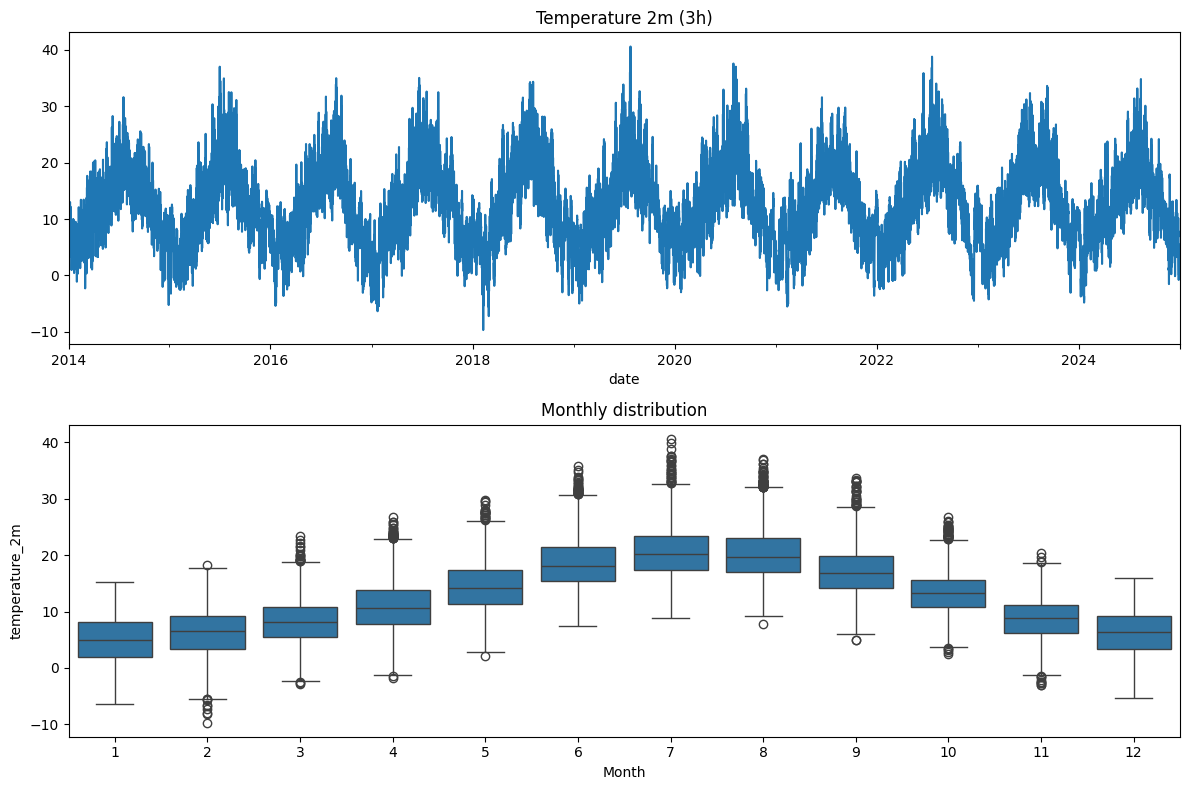

In [7]:
dfp = agg_df.reset_index()
dfp["month"] = dfp["date"].dt.month

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)

agg_df['temperature_2m'].plot(ax=axes[0], title='Temperature 2m (3h)')

sns.boxplot(data=dfp, x="month", y="temperature_2m", ax=axes[1])
axes[1].set_title("Monthly distribution")
axes[1].set_xlabel("Month")

plt.tight_layout()


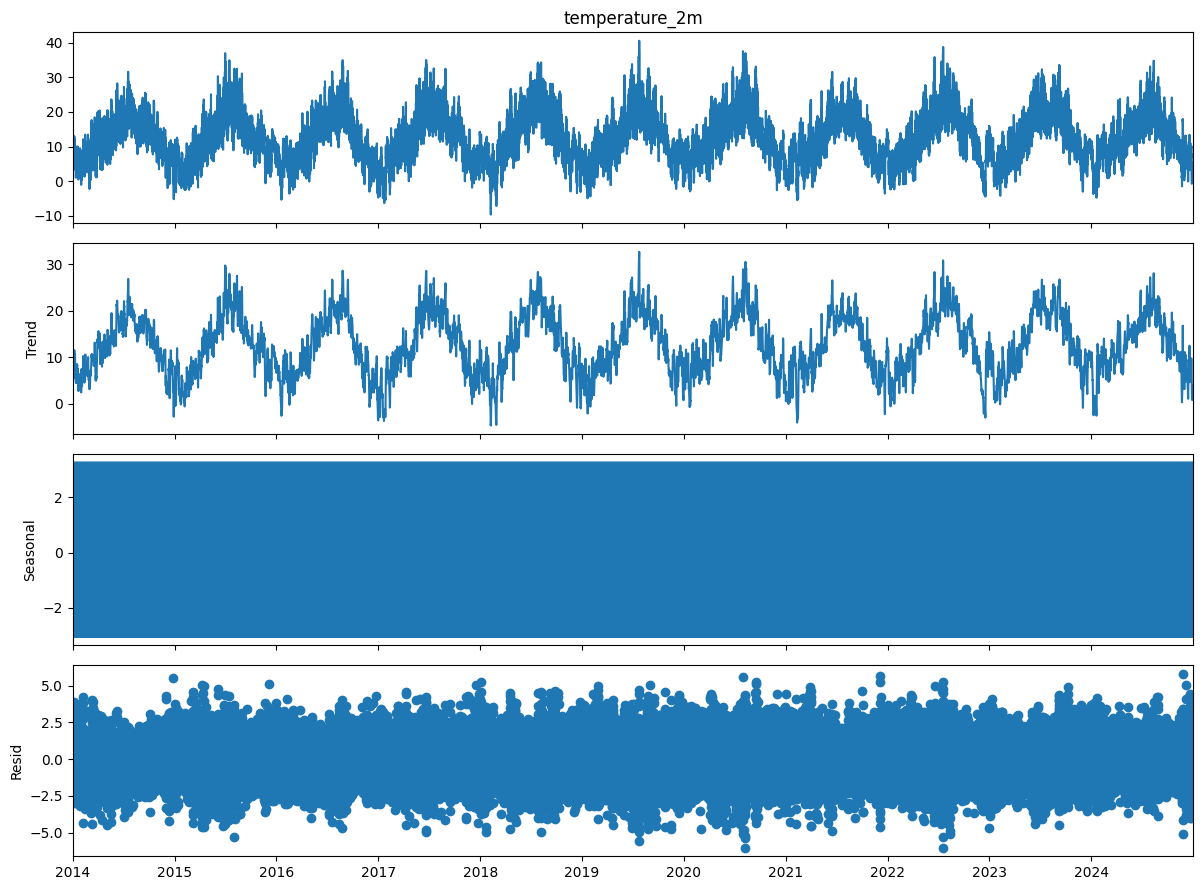

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomp = seasonal_decompose(agg_df['temperature_2m'], model='additive', period=8)  # 24h/3h
fig = decomp.plot()
fig.set_size_inches(12, 9)
plt.tight_layout()
